In [ ]:
# we study the forest.csv dataset which contains tree observations from four areas of the Roosevelt National Forest 
# in Colorado. All observations are cartographic variables from 30 meter x 30 meter sections of 
# forest. There are over half a million measurements total.
# we attempt to build a model that predicts what types of trees grow in an area based on the surrounding 
# characteristics 

In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
#matplotlib inline

In [69]:
# load the dataset
forest = pd.read_csv('./forest.csv')

# take a look at the various features of the dataset
print(f"Shape of data: {forest.shape}")
forest.head()

# there's a lot of data here (581012 entries) as well as many features (55) 
# the features are both numeric and categorical with the categorical features already contained in their own
# binary columns, so not in need of onehotencoding. The numeric features will need scaling.
# the column 'Cover_Type' are our class labels with the following key: {1:Spruce/Fir, 2:Lodgepole Pine,
# 3: Ponderosa Pine, 4:Cottonwood/Willow, 5:Aspen, 6:Douglas-fir, 7:Krummholz
#A huge list!
print(forest.info())

Shape of data: (581012, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2        

array([[<AxesSubplot:title={'center':'Elevation'}>,
        <AxesSubplot:title={'center':'Aspect'}>,
        <AxesSubplot:title={'center':'Slope'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Vertical_Distance_To_Hydrology'}>,
        <AxesSubplot:title={'center':'Horizontal_Distance_To_Roadways'}>],
       [<AxesSubplot:title={'center':'Hillshade_9am'}>,
        <AxesSubplot:title={'center':'Hillshade_Noon'}>,
        <AxesSubplot:title={'center':'Hillshade_3pm'}>],
       [<AxesSubplot:title={'center':'Horizontal_Distance_To_Fire_Points'}>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

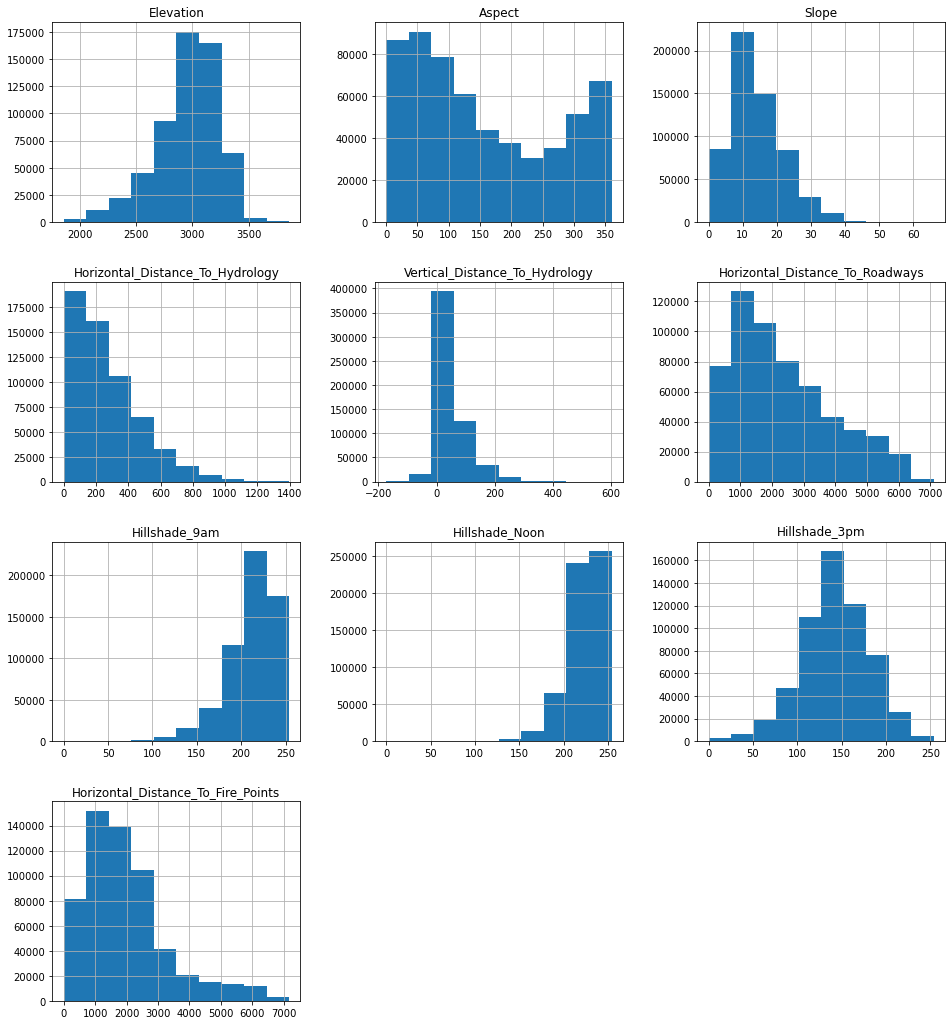

In [4]:
# no null calues and all integer numeric data. Very clean dataset. Since we won't have to do much in the way
# of tidying up this dataset let's do a bit more exploratory data analysis here

# let's take a look at the distributions of the continuous numeric data
forest.iloc[0:,0:10].hist(figsize = (16,18))
# there's clearly a lot of skew to pretty much all the features (maybe bar 'hillshade 3pm')

<AxesSubplot:>

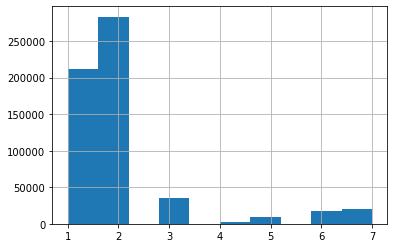

In [45]:
# what about the class labels, what's their dist?
forest['Cover_Type'].hist()
# seems like the dataset is dominated by Spruce/Fir and Lodgepole Pine

In [5]:
# there are a lot of categorical data columns and I wonder if some of these can be jetisoned and allow the algo
# to focus on more important features. Let's see

for col in forest.iloc[0:,10:]:
    count=forest[col].value_counts()
    print(col,count)

# yes, there is indeed a huge range, up to 5 orders of magnitude difference in counts for some features than others.
# we can maybe come back to this if need be at the end. However, count numbers tell only part of the story and 
# really we should be looking at the amount of variance or std dev to get an idea of how much variability is in
# our data and therefore how much information is contained in each feature. Since our dataset contains a large
# number of features, we might want to try principle-component-analysis (PCA) ultimately to narrow down the 
# dimensionality of the dataset in to the most important features. For now we'll inspect the st dev of the features.

Wilderness_Area1 0    320216
1    260796
Name: Wilderness_Area1, dtype: int64
Wilderness_Area2 0    551128
1     29884
Name: Wilderness_Area2, dtype: int64
Wilderness_Area3 0    327648
1    253364
Name: Wilderness_Area3, dtype: int64
Wilderness_Area4 0    544044
1     36968
Name: Wilderness_Area4, dtype: int64
Soil_Type1 0    577981
1      3031
Name: Soil_Type1, dtype: int64
Soil_Type2 0    573487
1      7525
Name: Soil_Type2, dtype: int64
Soil_Type3 0    576189
1      4823
Name: Soil_Type3, dtype: int64
Soil_Type4 0    568616
1     12396
Name: Soil_Type4, dtype: int64
Soil_Type5 0    579415
1      1597
Name: Soil_Type5, dtype: int64
Soil_Type6 0    574437
1      6575
Name: Soil_Type6, dtype: int64
Soil_Type7 0    580907
1       105
Name: Soil_Type7, dtype: int64
Soil_Type8 0    580833
1       179
Name: Soil_Type8, dtype: int64
Soil_Type9 0    579865
1      1147
Name: Soil_Type9, dtype: int64
Soil_Type10 0    548378
1     32634
Name: Soil_Type10, dtype: int64
Soil_Type11 0    568602
1 

<AxesSubplot:>

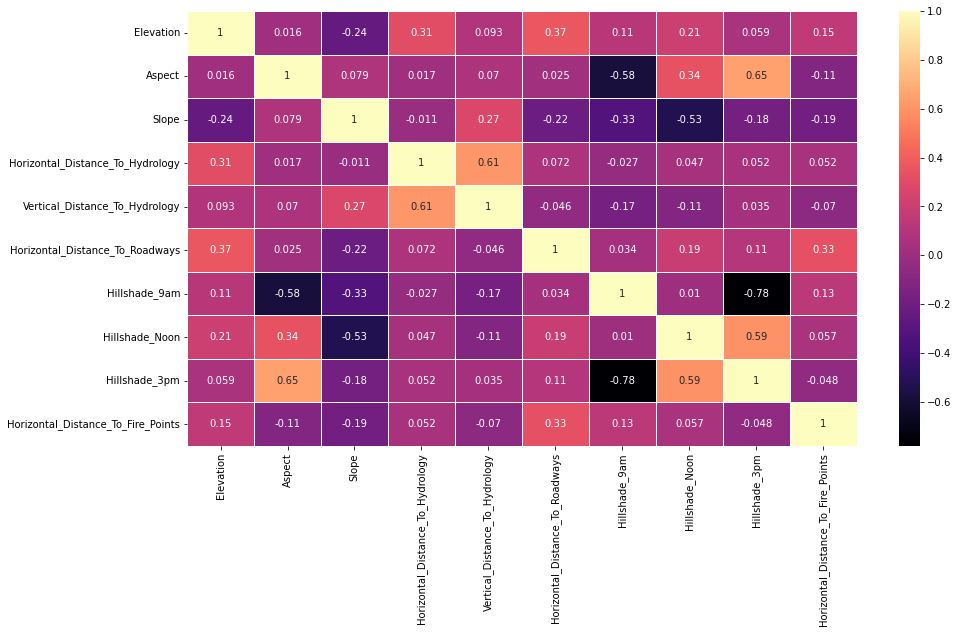

In [56]:
# let's also take a look at a correlation matrix for the continuous data

plt.figure(figsize=(15,8))
sns.heatmap(forest.iloc[0:,0:10].corr(),cmap='magma',linecolor='white',linewidths=1,annot=True)

In [ ]:
# unsurprisingly, shade and aspect are highly correlated, slope and elevation, slope and shade. This info might also
# come in handy when we try to refine our model i.e. we could remove some of these columns.

In [70]:
# let's onehotencode the labels

ct = ColumnTransformer([("Cover_Type", OneHotEncoder(),['Cover_Type'])],remainder="passthrough")
forest_transformed=ct.fit_transform(forest) # data is now in array form  

transformed_columns=ct.get_feature_names() # create a dataframe to check
forest_transformed_df=pd.DataFrame(forest_transformed,columns=transformed_columns) 

transformed_tree_columns=transformed_columns[0:7]
# for i in range(len(transformed_tree_columns)):
#     penguin_classes[i]=penguin_classes[i][12:]

In [71]:
# before scaling, let's split the data first to avoid information leakage.

# remove sparse data columns and one's with low std-dev
forest_std=forest.std()
forest_std_rem=[]
for i in range(len(forest_std)):
    if forest_std[i]<0.3:
        forest_std_rem.append(forest_std.index[i]) # create column list with std dev below 0.3 to be removed

forest_transformed_df.drop(forest_std_rem, axis=1, inplace=True)
X=forest_transformed_df.drop(columns=transformed_tree_columns) # features
y=forest_transformed_df[transformed_tree_columns] # labels

# we'll use a 80:10:10 split for our training:validation:testing datasets 
# to this end we'll use train_test_split twice

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

# # split the data in training and remaining dataset
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8)

# # we'll need this extra step for training and testing a NN
# # split remaining in to validation and testing sets
# test_size = 0.5
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)

In [72]:
# we can now re-scale the remaining non-categorical features to avoid unequal weighting in the ML algorithms

# need dataframe copies for normalisation and standardisation scaling
X_train_norm=X_train.copy()
# X_valid_norm=X_valid.copy()
X_test_norm=X_test.copy()
X_train_scale=X_train.copy()
# X_valid_scale=X_valid.copy()
X_test_scale=X_test.copy()

num=10 # number of continuous data feature columns

# fit scaler on non-categorical training data
norm = MinMaxScaler().fit(X_train.iloc[0:,0:10]) # select only the continuous data to transform
# transform training data
X_train_norm_noncat = norm.transform(X_train_norm.iloc[0:,0:num])
# transform validation data
# X_valid_norm_noncat = norm.transform(X_valid_norm.iloc[0:,0:10])
# transform testing data
X_test_norm_noncat = norm.transform(X_test.iloc[0:,0:num])
# need to recombine scaled data with categorical data
# we only actually need to use the copied datasets here when recombining as the above df slices didnt
# affect the dfs themselves
X_train_norm.iloc[0:,0:num]=X_train_norm_noncat
# X_valid_norm.iloc[0:,0:10]=X_valid_norm_noncat
X_test_norm.iloc[0:,0:num]=X_test_norm_noncat

# let's also standardise our data for comparison
scale = StandardScaler().fit(X_train.iloc[0:,0:num])
X_train_scale_noncat = scale.transform(X_train_scale.iloc[0:,0:num])
# X_valid_scale_noncat = scale.transform(X_valid_scale.iloc[0:,0:10])
X_test_scale_noncat = scale.transform(X_test_scale.iloc[0:,0:num])
X_train_scale.iloc[0:,0:num]=X_train_scale_noncat
# X_valid_scale.iloc[0:,0:10]=X_valid_scale_noncat
X_test_scale.iloc[0:,0:num]=X_test_scale_noncat

In [17]:
# let's try a k-nearest neighbors classifier first on the continuous numeric data as there are a lot of features
# and run-times are long.

neighbors=3

knn = KNeighborsClassifier(n_neighbors=neighbors)
    
#Fit the model
knn.fit(X_train_norm_noncat, y_train)

train_accuracy = knn.score(X_train_norm_noncat, y_train) #Compute accuracy on the training set

test_accuracy = knn.score(X_test_norm_noncat, y_test) #Compute accuracy on the validation set
print(test_accuracy)
#test_accuracy=0.9196227259427548

0.9286163007839728


In [ ]:
# let's see how adding certain feature columns back in helps. Let's add the wilderness_area features back in 
# test_accuracy=0.9286163007839728. A decent improvement, let's try some more features.

In [10]:
# k-nearest neighbors classifier on feature columns with std dev above 0.3

neighbors=3

knn = KNeighborsClassifier(n_neighbors=neighbors)
    
#Fit the model
knn.fit(X_train_norm, y_train)

train_accuracy = knn.score(X_train_norm, y_train) #Compute accuracy on the training set

test_accuracy = knn.score(X_test_norm, y_test) #Compute accuracy on the validation set
print(test_accuracy)
#test_accuracy=0.929674793249744

# not a huge improvement. We've gone from improving the accuracy of the model at the 2 sig. fig. level by including 
# the wilderness_area features (which have high variance), but then we don't see much improvement over that
# wiht the inclusion of features with std devs over 0.25. This suggests we're approaching convergence in our
# model refinement, at least with respect to feature selection. We'll come back to this when we try PCA.

0.929674793249744


In [78]:
# let's do some cross-validation first to get an idea of how good these accuracy scores really are

from sklearn.model_selection import cross_val_score, cross_val_predict

knn = KNeighborsClassifier(n_neighbors = 3)

scores = cross_val_score(knn, X_train_norm, y_train.values, cv=5, scoring='accuracy')

print(scores)

# score=[0.9640068  0.96501796 0.9644586  0.96587853 0.9648132 ] (for raw data)
# score= [0.92212947 0.92392591 0.92246294 0.92586218 0.92345177]
# score=[0.91195327 0.91285687 0.91272778 0.91425529 0.91272684] (for scaled data)
# score=[0.69109959 0.69315419 0.69663949 0.6921     0.6951087 ] (with PCA)

# CV here appears to show that the model predictions are reliable up to maybe the 2 s.f. at most. However, 
# surprisngly we see that the unscale, raw data actually produces higher training accuracy results. Could this
# be due to overfitting?

[0.69109959 0.69315419 0.69663949 0.6921     0.6951087 ]


In [37]:
%%time

neighbors = np.arange(1,20)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
#     Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
#     print(k)

#     #Fit the model
    knn.fit(X_train_norm[1:10000].values, y_train[1:10000].values)

#     #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_norm[1:10000].values, y_train[1:10000].values)

#     Compute accuracy on the validation set
    test_accuracy[i] = knn.score(X_test_norm.values[1:10000], y_test[1:10000].values) 

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
CPU times: user 1min 5s, sys: 433 ms, total: 1min 6s
Wall time: 1min 6s


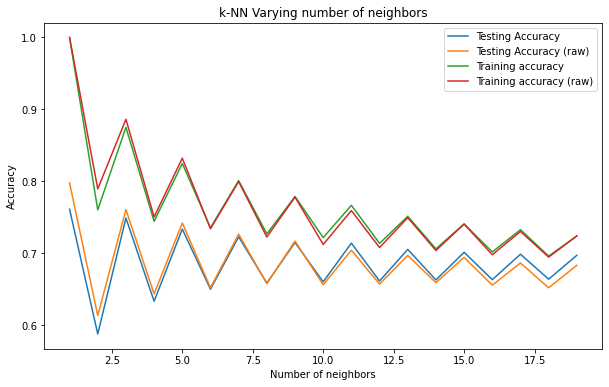

In [44]:
# visulise results of knn classifier n.b. the plot displayed corresponds to only a fraction of the data, since
# run times were so long for the full dataset. 
plt.figure(figsize=(10,6))
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, test_accuracy_raw, label='Testing Accuracy (raw)')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.plot(neighbors, train_accuracy_raw, label='Training accuracy (raw)')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

# we can see that a k of 3,5 is probably sufficient for our purposes. We'll continus with that on the whole dataset
# we've also plotted here the testing and training accuracies for the raw (unscaled) data as well for comparison,
# given our surprise at the higher accuracies it seemed to produce at least with CV on the training data.
# It does appear as though the scaled data out performs the raw data for higher k-valued, more complex models,
# but for some reason it slightly outperforms for low k-values. This is a bit perplexing. One would imagine
# overfitting to be a problem for higher k-valued, more complex, models as so this is probably not the reason.

In [ ]:
# at this point we could try to improve the model's performance with a hyperparameter gridsearch however I've done
# this in past projects and I'm more interested here in performing PCA. This is also motivated by the fact that
# the KNNClassifier has a lot of inuilt functionality that attempts to determine the best hyperparameters to use
# already and given the size of the dataset (in terms of sample size and dimensionality) the algorithm has likely
# already converged in this sense. Eithr way I'm not so interested in testing that as much as I am trying PCA
# given it's relevance to large datasets and especially those with a wide range of variances to the features. 
# let's begin

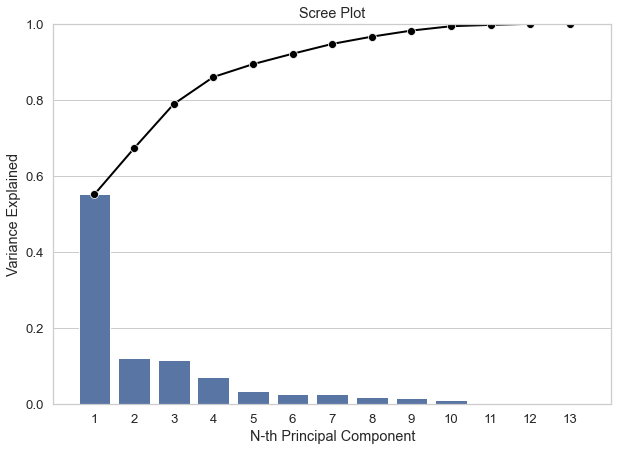

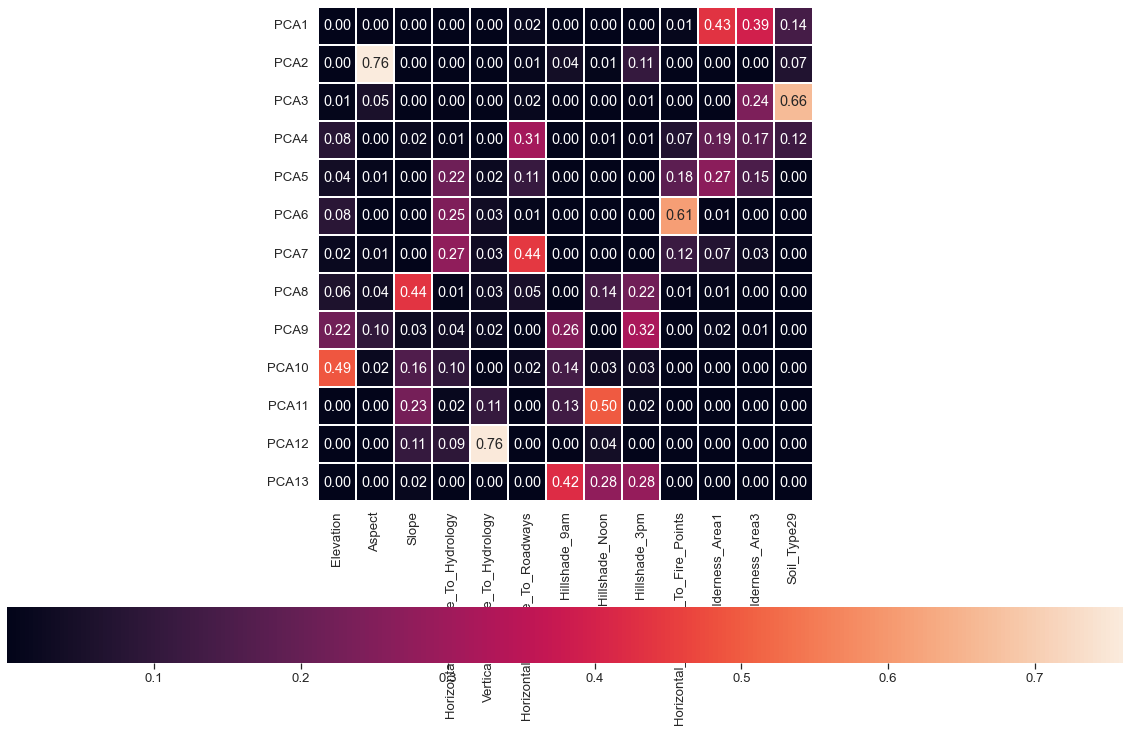

In [73]:
from sklearn.decomposition import PCA
import seaborn as sns

# Perform PCA (w/o limits on n_components)
pca = PCA()
_ = pca.fit_transform(X_train_norm)
PC_components = np.arange(pca.n_components_) + 1

# Scree Plot
_ = sns.set(style='whitegrid', font_scale=1.2)
fig, ax = plt.subplots(figsize=(10, 7))
_ = sns.barplot(x=PC_components, y=pca.explained_variance_ratio_, color='b')
_ = sns.lineplot(x=PC_components-1, y=np.cumsum(pca.explained_variance_ratio_), color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

plt.title('Scree Plot')
plt.xlabel('N-th Principal Component')
plt.ylabel('Variance Explained')
plt.ylim(0, 1)
plt.show()

# we can also look at the combinations of variables that created each principal component 
plt.figure(figsize=(20,13))
_ = sns.heatmap(pca.components_**2,
                 yticklabels=["PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(list(X.columns)),
                 annot=True,
                 fmt='.2f',
                 square=True,
                 linewidths=0.05,
                 cbar_kws={"orientation": "horizontal"})

In [76]:
# based on the PCA above, I'm inclined to go with 4 principle components as this will capture 90% of the data. Let's 
# try it

pca = PCA(n_components=4)
X_train_norm_pca = pca.fit_transform(X_train_norm)

# running our transformed training data back through our KNNclassifier produces quite poor predictions. Maybe, our
# crude attempt at feature selection with std dev above 0.3 is already enough to produce good results.
# sometimes simpler is better

In [ ]:
# we'll stop here as I will try some other models next (see next notebook). In particular I would like to try
# some decision tree based models as they can also perform quite well on these kinds of datasets. However, hopefully
# I can come back and try to understand this scaling question a bit better.